# Model Selection

## Mục tiêu

- So sánh hiệu suất tất cả các mô hình trên tập validation
- Xác định mô hình tốt nhất dựa trên MAE loss
- Dự đoán tuổi thọ trên tập test sử dụng mô hình tốt nhất
- Phân tích kết quả dự đoán trên test set, bao gồm:
  - Kết quả dự đoán chi tiết cho từng quốc gia
  - So sánh validation vs test performance (phát hiện overfitting)
  - Phân tích lỗi theo các nhóm tuổi thọ
  - Vẽ biểu đồ insights

## Bước 1 - Import các thư viện cần thiết

In [1]:
import os
import joblib
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

# Set style cho biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

## Bước 2 - Đọc dữ liệu validation và test

In [5]:
# Đọc dữ liệu
train_df = pd.read_csv('../data/processed/train.csv')
val_df = pd.read_csv('../data/processed/val.csv')
test_df = pd.read_csv('../data/processed/test.csv')

print("THÔNG TIN DỮ LIỆU VALIDATION VÀ TEST")
print("="*60)
print(f"Kích thước tập validation: {val_df.shape}")
print(f"Kích thước tập test: {test_df.shape}")

# Định nghĩa các cột dùng để dự đoán
feature_cols = [col for col in val_df.columns
                if col not in ['life_expectancy', 'country_name', 'country_code']]

X_train =train_df[feature_cols]
y_train = train_df['life_expectancy']

# Tách X và y cho tập validation
X_val = val_df[feature_cols]
y_val = val_df['life_expectancy']

# Tách X và y cho tập test
X_test = test_df[feature_cols]
y_test = test_df['life_expectancy']

print(f"\nSố lượng đặc trưng: {len(feature_cols)}")

THÔNG TIN DỮ LIỆU VALIDATION VÀ TEST
Kích thước tập validation: (1042, 13)
Kích thước tập test: (1042, 13)

Số lượng đặc trưng: 10


## Bước 3 - Load tất cả các mô hình

In [6]:
BASE_DIR = Path('../models')

# Dictionary lưu các mô hình
models = {}

# ===== 1. Linear Models =====
models['Linear'] = joblib.load(BASE_DIR / "1_linear_regression" / "linear.pkl")
models['Ridge'] = joblib.load(BASE_DIR / "1_linear_regression" / "ridge.pkl")
models['Lasso'] = joblib.load(BASE_DIR / "1_linear_regression" / "lasso.pkl")

# ===== 2. SVM =====
models['LinearSVR'] = joblib.load(BASE_DIR / "2_SVM_regression" / "linear_svr.pkl")
models['SVR_RBF'] = joblib.load(BASE_DIR / "2_SVM_regression" / "svr_rbf.pkl")

# ===== 3. Decision Tree =====
models['DecisionTree'] = joblib.load(BASE_DIR / "3_decision_tree" / "decision_tree.pkl")

# ===== 4. Random Forest =====
models['RandomForest'] = joblib.load(BASE_DIR / "4_random_forest" / "random_forest.pkl.gz")

# ===== 5. GBM =====
models['GBM'] = joblib.load(BASE_DIR / "5_GBM" / "GBM.pkl.gz")

# ===== 6. LightGBM =====
models['LightGBM'] = joblib.load(BASE_DIR / "6_lightgbm" / "lightgbm.pkl")

# ===== 7. XGBoost =====
models['XGBoost'] = joblib.load(BASE_DIR / "7_xgboost" / "xgboost.pkl.gz")

# ===== 8. CatBoost =====
models['CatBoost'] = joblib.load(BASE_DIR / "8_catboost" / "catboost.pkl.gz")

# ===== 9. Voting Ensemble =====
voting_ensemble_data = joblib.load(BASE_DIR / "9_ensemble_learning" / "voting_ensemble.pkl.gz")
models['Voting_Ensemble'] = voting_ensemble_data['base_models']

# ===== 10. Stacking Ensemble =====
stacking_ensemble_data = joblib.load(BASE_DIR / "9_ensemble_learning" / "stacking_ensemble.pkl.gz")
models['Stacking_Ensemble'] = stacking_ensemble_data['stacking_model']

print("TẤT CẢ CÁC MÔ HÌNH ĐÃ ĐƯỢC LOAD")
print("="*60)
print(f"Số lượng mô hình: {len(models)}")
for i, model_name in enumerate(models.keys(), 1):
    print(f"{i:2d}. {model_name}")

c:\Users\DELL\.conda\envs\course\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\DELL\.conda\envs\course\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


TẤT CẢ CÁC MÔ HÌNH ĐÃ ĐƯỢC LOAD
Số lượng mô hình: 13
 1. Linear
 2. Ridge
 3. Lasso
 4. LinearSVR
 5. SVR_RBF
 6. DecisionTree
 7. RandomForest
 8. GBM
 9. LightGBM
10. XGBoost
11. CatBoost
12. Voting_Ensemble
13. Stacking_Ensemble


## Bước 3 - Kiểm tra MAE, RMSE và R2 của các mô hình trên tập training 

In [12]:
# Đánh giá từng mô hình
train_results = {}

print("ĐÁNH GIÁ TRAINING:")
print("="*90)
print(f"{'Model':<20} | {'MAE':<10} | {'RMSE':<10} | {'R²':<10}")
print("-"*90)

for model_name, model in models.items():
    if model_name != 'Voting_Ensemble':
        y_pred = model.predict(X_train)
        mae = mean_absolute_error(y_train, y_pred)
        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        r2 = r2_score(y_train, y_pred)
        
        train_results[model_name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"{model_name:<20} | {mae:<10.4f} | {rmse:<10.4f} | {r2:<10.4f}")

# Thêm Voting Ensemble
base_models = voting_ensemble_data['base_models']
weights = voting_ensemble_data['weights']

y_train_voting = np.zeros(len(y_train))
for model_name, weight in weights.items():
    model = base_models[model_name]
    y_pred_model = model.predict(X_train)
    y_train_voting += weight * y_pred_model

mae_voting = mean_absolute_error(y_train, y_train_voting)
rmse_voting = np.sqrt(mean_squared_error(y_train, y_train_voting))
r2_voting = r2_score(y_train, y_train_voting)

train_results['Voting_Ensemble'] = {'MAE': mae_voting, 'RMSE': rmse_voting, 'R2': r2_voting}

print(f"{'Voting_Ensemble':<20} | {mae_voting:<10.4f} | {rmse_voting:<10.4f} | {r2_voting:<10.4f}")
print("="*90)

ĐÁNH GIÁ TRAINING:
Model                | MAE        | RMSE       | R²        
------------------------------------------------------------------------------------------
Linear               | 3.1661     | 4.2541     | 0.7670    
Ridge                | 3.1609     | 4.2654     | 0.7658    
Lasso                | 3.1607     | 4.2654     | 0.7658    
LinearSVR            | 6.5051     | 7.7067     | 0.2354    
SVR_RBF              | 1.7222     | 2.8380     | 0.8963    
DecisionTree         | 1.6345     | 2.2304     | 0.9360    
RandomForest         | 0.2005     | 0.3818     | 0.9981    
GBM                  | 0.1569     | 0.2154     | 0.9994    
LightGBM             | 0.2021     | 0.3907     | 0.9980    
XGBoost              | 0.0968     | 0.1298     | 0.9998    
CatBoost             | 0.1372     | 0.1807     | 0.9996    
Stacking_Ensemble    | 0.1903     | 0.2809     | 0.9990    
Voting_Ensemble      | 0.2134     | 0.3080     | 0.9988    


## Bước 4 - Đánh giá tất cả các mô hình trên tập validation

In [13]:
# Đánh giá từng mô hình
val_results = {}

print("ĐÁNH GIÁ VALIDATION")
print("="*90)
print(f"{'Model':<20} | {'MAE':<10} | {'RMSE':<10} | {'R²':<10}")
print("-"*90)

for model_name, model in models.items():
    if model_name != 'Voting_Ensemble':
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        val_results[model_name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"{model_name:<20} | {mae:<10.4f} | {rmse:<10.4f} | {r2:<10.4f}")

y_val_voting = np.zeros(len(y_val))
for model_name, weight in weights.items():
    model = base_models[model_name]
    y_pred_model = model.predict(X_val)
    y_val_voting += weight * y_pred_model

mae_voting = mean_absolute_error(y_val, y_val_voting)
rmse_voting = np.sqrt(mean_squared_error(y_val, y_val_voting))
r2_voting = r2_score(y_val, y_val_voting)

val_results['Voting_Ensemble'] = {'MAE': mae_voting, 'RMSE': rmse_voting, 'R2': r2_voting}

print(f"{'Voting_Ensemble':<20} | {mae_voting:<10.4f} | {rmse_voting:<10.4f} | {r2_voting:<10.4f}")
print("="*90)


ĐÁNH GIÁ VALIDATION
Model                | MAE        | RMSE       | R²        
------------------------------------------------------------------------------------------
Linear               | 3.2063     | 4.2503     | 0.7625    
Ridge                | 3.1974     | 4.2537     | 0.7622    
Lasso                | 3.1976     | 4.2540     | 0.7621    
LinearSVR            | 6.6079     | 7.7801     | 0.2044    
SVR_RBF              | 2.3519     | 3.3725     | 0.8505    
DecisionTree         | 2.1752     | 3.1417     | 0.8703    
RandomForest         | 0.9873     | 1.5919     | 0.9667    
GBM                  | 0.9924     | 1.5147     | 0.9698    
LightGBM             | 0.9425     | 1.5405     | 0.9688    
XGBoost              | 0.8804     | 1.3881     | 0.9747    
CatBoost             | 0.8416     | 1.3889     | 0.9746    
Stacking_Ensemble    | 0.8468     | 1.3936     | 0.9745    
Voting_Ensemble      | 0.9058     | 1.4354     | 0.9729    


## Bước 5 - Xác định mô hình tốt nhất

Đối với bài toán dự đoán tuổi thọ trung bình của các quốc gia cùng với bộ dữ liệu hiện có, ta sử dụng MAE làm metric chính để chọn ra model tốt nhất. 

Lý do:
1. MAE đo sai số theo đúng đơn vị thực tế (năm tuổi thọ)
- Ví dụ: MAE = 2.3 tức là mô hình sai trung bình 2.3 năm.
- Rất dễ diễn giải, phù hợp cho báo cáo khoa học / y tế / xã hội học.
2. MAE ổn định hơn RMSE trong phân phối tuổi thọ.
- RMSE phạt sai số lớn gấp bình phương, nên khi có nhiều outliers trong bộ dữ liệu:
    - RMSE tăng mạnh
    - Mô hình bị đánh giá sai lệch
- Trong khi đó, MAE đánh giá “đều” toàn bộ quốc gia, giúp mô hình không bị thiên về một nhóm đặc biệt.
3. R² không phù hợp làm metric chọn mô hình do:
- Khó diễn giải theo “tuổi thọ”.
- Phụ thuộc độ rộng phân phối target.

In [14]:
# Tạo DataFrame từ kết quả validation
val_df_results = pd.DataFrame(val_results).T.reset_index()
val_df_results.columns = ['Model', 'MAE', 'RMSE', 'R2']
val_df_results = val_df_results.sort_values('MAE').reset_index(drop=True)

print("\nBÁNG XẾP HẠNG MÔ HÌNH (Sắp xếp theo MAE)")
print("="*90)
display(val_df_results)

# Xác định mô hình tốt nhất
best_model_name = val_df_results.iloc[0]['Model']
best_mae = val_df_results.iloc[0]['MAE']
best_rmse = val_df_results.iloc[0]['RMSE']
best_r2 = val_df_results.iloc[0]['R2']

print("\n" + "="*90)
print(f"MÔ HÌNH TỐT NHẤT: {best_model_name}")
print("-"*90)
print(f"MAE  : {best_mae:.4f}")
print(f"RMSE : {best_rmse:.4f}")
print(f"R²   : {best_r2:.4f}")


BÁNG XẾP HẠNG MÔ HÌNH (Sắp xếp theo MAE)


,Model,MAE,RMSE,R2
0,CatBoost,0.841582,1.388874,0.974645
1,Stacking_Ensemble,0.846778,1.393554,0.974474
2,XGBoost,0.880434,1.388145,0.974671
3,Voting_Ensemble,0.905769,1.435404,0.972917
4,LightGBM,0.942467,1.540534,0.968805
5,RandomForest,0.987314,1.591879,0.966691
6,GBM,0.992402,1.514710,0.969842
7,DecisionTree,2.175197,3.141676,0.870262
8,SVR_RBF,2.351907,3.372481,0.850500
9,Ridge,3.197386,4.253684,0.762166



MÔ HÌNH TỐT NHẤT: CatBoost
------------------------------------------------------------------------------------------
MAE  : 0.8416
RMSE : 1.3889
R²   : 0.9746


## Bước 6 - Dự đoán trên tập test sử dụng mô hình tốt nhất

### 6.1. Đánh giá mô hình trên tập test sử dụng 3 metrics: MAE, RMSE và R2

In [15]:
# Load mô hình tốt nhất
if best_model_name == 'Voting_Ensemble':
    y_test_pred = np.zeros(len(y_test))
    for model_name, weight in weights.items():
        model = base_models[model_name]
        y_pred_model = model.predict(X_test)
        y_test_pred += weight * y_pred_model
else:
    best_model = models[best_model_name]
    y_test_pred = best_model.predict(X_test)

# Tính metrics trên test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\nKẾT QUẢ DỰ ĐOÁN TRÊN TẬP TEST")
print("="*90)
print(f"Mô hình: {best_model_name}")
print("-"*90)
print(f"MAE  : {test_mae:7.4f}")
print(f"RMSE : {test_rmse:7.4f}")
print(f"R²   : {test_r2:7.4f}")


KẾT QUẢ DỰ ĐOÁN TRÊN TẬP TEST
Mô hình: CatBoost
------------------------------------------------------------------------------------------
MAE  :  0.7907
RMSE :  1.3621
R²   :  0.9759


### 6.2. Kết quả dự đoán chi tiết trên test set

In [16]:
# Tạo DataFrame kết quả dự đoán
test_results_df = pd.DataFrame({
    'Quốc gia': test_df['country_name'],
    'Tuổi thọ thực': y_test.values,
    'Tuổi thọ dự đoán': y_test_pred,
    'Chênh lệch': np.abs(y_test.values - y_test_pred),
    'Chênh lệch %': (np.abs(y_test.values - y_test_pred) / y_test.values) * 100
})

# Sắp xếp theo lỗi giảm dần
test_results_df = test_results_df.sort_values('Chênh lệch', ascending=False).reset_index(drop=True)

print("\nKẾT QUẢ DỰ ĐOÁN CHI TIẾT (Sắp xếp theo chênh lệch tuổi lớn nhất)")
print("="*100)
display(test_results_df.round(4))

# Thống kê lỗi
print("\n" + "="*100)
print("THỐNG KÊ LỖI DỰ ĐOÁN")
print("="*100)
print(f"Chênh lệch trung bình (MAE)     : {test_results_df['Chênh lệch'].mean():.4f} năm")
print(f"Chênh lệch trung bình (%)       : {test_results_df['Chênh lệch %'].mean():.4f}%")
print(f"Chênh lệch cao nhất             : {test_results_df['Chênh lệch'].max():.4f} năm ({test_results_df['Chênh lệch %'].max():.4f}%)")
print(f"Chênh lệch thấp nhất            : {test_results_df['Chênh lệch'].min():.4f} năm ({test_results_df['Chênh lệch %'].min():.4f}%)")
print(f"Độ lệch chuẩn (std)             : {test_results_df['Chênh lệch'].std():.4f} năm")


KẾT QUẢ DỰ ĐOÁN CHI TIẾT (Sắp xếp theo chênh lệch tuổi lớn nhất)


,Quốc gia,Tuổi thọ thực,Tuổi thọ dự đoán,Chênh lệch,Chênh lệch %
0,Central African Republic,31.5300,50.8348,19.3048,61.2268
1,"Somalia, Fed. Rep.",32.4530,48.7014,16.2484,50.0676
2,West Bank and Gaza,65.1700,74.9890,9.8190,15.0667
3,Greenland,66.6117,72.4664,5.8547,8.7893
4,"Korea, Dem. People's Rep.",60.8770,66.1004,5.2234,8.5803
...,...,...,...,...,...
1037,China,72.6750,72.6730,0.0020,0.0028
1038,Thailand,74.6690,74.6676,0.0014,0.0018
1039,Bolivia,64.1820,64.1807,0.0013,0.0021
1040,"Korea, Rep.",76.7659,76.7667,0.0009,0.0012



THỐNG KÊ LỖI DỰ ĐOÁN
Chênh lệch trung bình (MAE)     : 0.7907 năm
Chênh lệch trung bình (%)       : 1.2287%
Chênh lệch cao nhất             : 19.3048 năm (61.2268%)
Chênh lệch thấp nhất            : 0.0007 năm (0.0010%)
Độ lệch chuẩn (std)             : 1.1097 năm


## Bước 7 - So sánh Validation vs Test

In [19]:
# Tạo bảng so sánh
comparison_df = pd.DataFrame({
    'Metrics': ['MAE', 'RMSE', 'R²'],
    'Validation': [best_mae, best_rmse, best_r2],
    'Test': [test_mae, test_rmse, test_r2],
    'Difference': [abs(test_mae - best_mae), abs(test_rmse - best_rmse), abs(test_r2 - best_r2)]
})

print("\nSO SÁNH VALIDATION VS TEST")
print("-"*90)
display(comparison_df)


SO SÁNH VALIDATION VS TEST
------------------------------------------------------------------------------------------


,Metrics,Validation,Test,Difference
0,MAE,0.841582,0.790688,0.050895
1,RMSE,1.388874,1.362131,0.026743
2,R²,0.974645,0.975948,0.001303


### Nhận xét:
- Cả ba độ đo (MAE, RMSE, R2) đều có kết quả tốt hơn trên tập test.

- Điều này thể hiện khả năng tổng quát hóa của mô hình CatBoost. Mô hình không chỉ học vẹt các quy luật trong tập train/validation mà đã nắm bắt được bản chất thực sự của dữ liệu.

## Bước 8 - Vẽ biểu đồ phân tích

### 8.1. Vẽ biểu đồ phân tích kết quả dự đoán trên test set

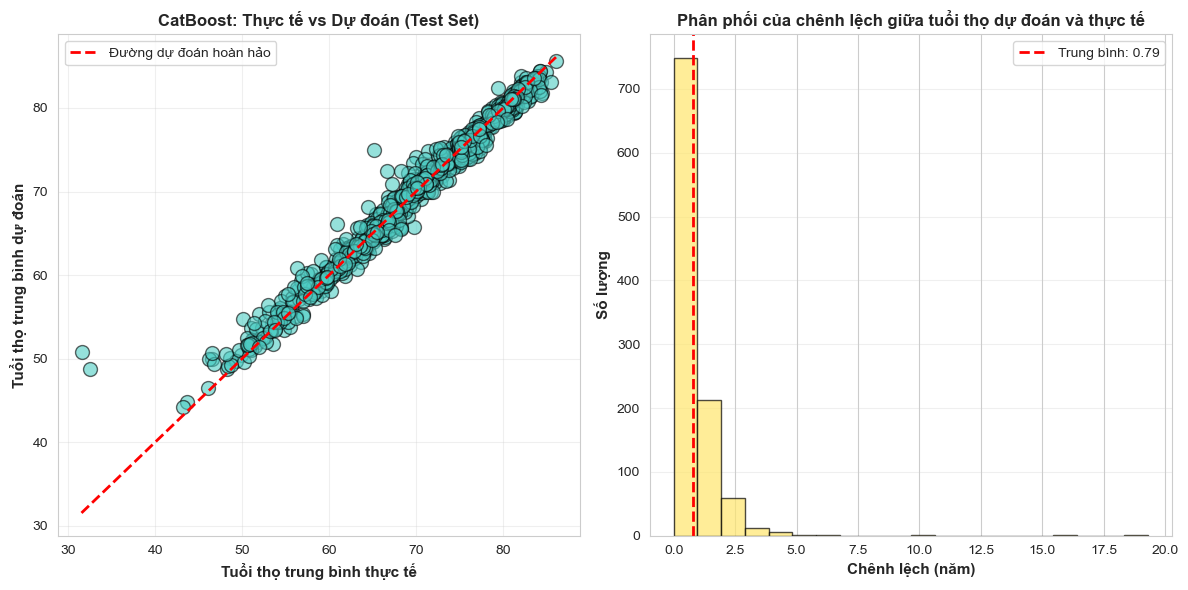

In [20]:
# 1. Biểu đồ so sánh các mô hình
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ con 1: Thực tế vs Dự đoán
ax1 = axes[0]
ax1.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', s=100, color='#4ECDC4')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Đường dự đoán hoàn hảo')
ax1.set_xlabel('Tuổi thọ trung bình thực tế', fontsize=11, fontweight='bold')
ax1.set_ylabel('Tuổi thọ trung bình dự đoán', fontsize=11, fontweight='bold')
ax1.set_title(f'{best_model_name}: Thực tế vs Dự đoán (Test Set)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Biểu đồ con 2: Phân phối lỗi
ax2 = axes[1]
ax2.hist(test_results_df['Chênh lệch'], bins=20, edgecolor='black', alpha=0.7, color='#FFE66D')
ax2.axvline(test_results_df['Chênh lệch'].mean(), color='red', linestyle='--', linewidth=2, label=f"Trung bình: {test_results_df['Chênh lệch'].mean():.2f}")
ax2.set_xlabel('Chênh lệch (năm)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Số lượng', fontsize=11, fontweight='bold')
ax2.set_title('Phân phối của chênh lệch giữa tuổi thọ dự đoán và thực tế', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
os.makedirs('../model_selection', exist_ok=True)
plt.savefig('../model_selection/model_selection.png', dpi=300, bbox_inches='tight')
plt.show()

### 8.2. Nhận xét về biểu đồ phân tích

- Biểu đồ bên trái cho thấy các dự đoán của CatBoost tập trung sát đường thẳng lý tưởng (đường đỏ), với ít điểm ngoại lệ, chứng tỏ mô hình có khả năng tổng quát hóa trên test set.

- Phân phối chênh lệch tuổi thọ dự đoán và thực tế hầu hết tập trung ở dưới 2 năm, với mức trung bình là 0.85 năm - rất tốt cho ứng dụng thực tế.

## Bước 9 - Lưu kết quả

In [21]:
# Lưu các kết quả
os.makedirs('../model_selection', exist_ok=True)

# 1. Lưu ranking validation
val_df_results.to_csv('../model_selection/model_validation_ranking.csv', index=False)

# 2. Lưu kết quả test chi tiết
test_results_df.to_csv('../model_selection/test_predictions_detailed.csv', index=False)

# 3. Lưu so sánh val vs test
comparison_df.to_csv('../model_selection/validation_test_comparison.csv', index=False)

print("TÓM TẮT KẾT QUẢ")
print("="*100)
print(f"Mô hình tốt nhất: {best_model_name}")
print(f"Validation - MAE: {best_mae:.4f}, RMSE: {best_rmse:.4f}, R²: {best_r2:.4f}")
print(f"Test       - MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

TÓM TẮT KẾT QUẢ
Mô hình tốt nhất: CatBoost
Validation - MAE: 0.8416, RMSE: 1.3889, R²: 0.9746
Test       - MAE: 0.7907, RMSE: 1.3621, R²: 0.9759


## Kết luận

### Qua các bước tiến hành, ta đã:
1. So sánh tất cả 12 mô hình trên validation set.

2. Xác định mô hình tốt nhất dựa trên MAE metric.

3. Dự đoán tuổi thọ trên test set sử dụng mô hình tốt nhất.

4. Phân tích chi tiết kết quả

5. Lưu tất cả kết quả để phục vụ cho báo cáo.

### Kết luận:
   - CatBoost là lựa chọn tối ưu cho bài toán dự đoán tuổi thọ trung bình của các quốc gia dựa trên bộ dữ liệu từ World Bank.

   - CatBoost thể hiện khả năng tổng quát hóa cao trên test set, kết quả của CatBoost đủ tốt cho dự báo tuổi thọ trung bình trong thực tế.

   - Dữ liệu hiện có có cấu trúc phi tuyến phức tạp.
   Tuổi thọ phụ thuộc vào tương tác phức tạp giữa nhiều yếu tố: GDP bình quân đầu người, lực lượng lao động, tăng trưởng GDP,...